In [11]:
%matplotlib
%matplotlib inline
import os
os.chdir('/content')

!python Chap_12_Reinforced_Learning_Training.py

Using matplotlib backend: agg
2023-05-30 03:51:35.147369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-30 03:51:37.959389: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
트레이닝을 시작합니다.
/content/Chap_12_Reinforced_Learning_Training.py:168: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.gameOver = np.empty(self.maxMemory, dtype = np.bool)
W0530 03:51:39.259461 140077718792000 polymorphic_function.py:156] 5 out of the last 5 calls to <function _BaseOptimizer._update_step_

In [12]:
from Chap_12_Reinforced_Learning_Training import CatchEnvironment, DQN
from IPython import display
import matplotlib.patches as patches
import pylab as pl
import time
import tensorflow as tf
import os

In [13]:
# 설정값들을 정의합니다.
gridSize = 10
maxGames = 30
DQN_model = DQN()
env = CatchEnvironment(gridSize)
winCount = 0
loseCount = 0
numberOfGames = 0

In [14]:
# 현재 상태를 그리기 위한 drawState 함수를 정의합니다.
def drawState(fruitRow, fruitColumn, basket, gridSize):
  # 과일이 몇번째 세로축에 있는지 정의합니다.
  fruitX = fruitColumn 
  # 과일이 몇번째 가로축에 있는지 정의합니다.
  fruitY = (gridSize - fruitRow + 1)
  # 승리 횟수, 패배 횟수, 전체 게임 횟수를 화면 상단에 출력합니다.
  statusTitle = "Wins: " + str(winCount) + "  Losses: " + str(loseCount) + "  TotalGame: " + str(numberOfGames)
  axis.set_title(statusTitle, fontsize=30)
  for p in [
    # 배경의 위치를 지정합니다.
    patches.Rectangle(
        ((ground - 1), (ground)), 11, 10,
        facecolor="#000000"      # Black
    ),
    # 바구니의 위치를 지정합니다.
    patches.Rectangle(
        (basket - 1, ground), 2, 0.5,
        facecolor="#FF0000"     # Red
    ),
    # 과일의 위치를 지정합니다.
    patches.Rectangle(
        (fruitX - 0.5, fruitY - 0.5), 1, 1,
        facecolor="#0000FF"       # Blue
    ),   
    ]:
      axis.add_patch(p)
  display.clear_output(wait=True)
  display.display(pl.gcf())

In [15]:
# 저장된 파라미터를 불러옵니다.
ckpt = tf.train.Checkpoint(model=DQN_model)
latest_ckpt = tf.train.latest_checkpoint(os.getcwd())
#latest_ckpt = '/content/model.ckpt-201'

ckpt.restore(latest_ckpt)

print('저장된 파라미터를 불러왔습니다!')

저장된 파라미터를 불러왔습니다!


In [16]:
# GIF를 만들기위해 설치합니다.
!pip install imageio

!mkdir '/content/generated_output/'

import glob
import imageio
import matplotlib.pyplot as plt
import PIL

def display_image(epoch_no):
  return PIL.Image.open('/content/generated_output/image_at_epoch_{:04d}.png'.format(epoch_no))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/content/generated_output/’: File exists


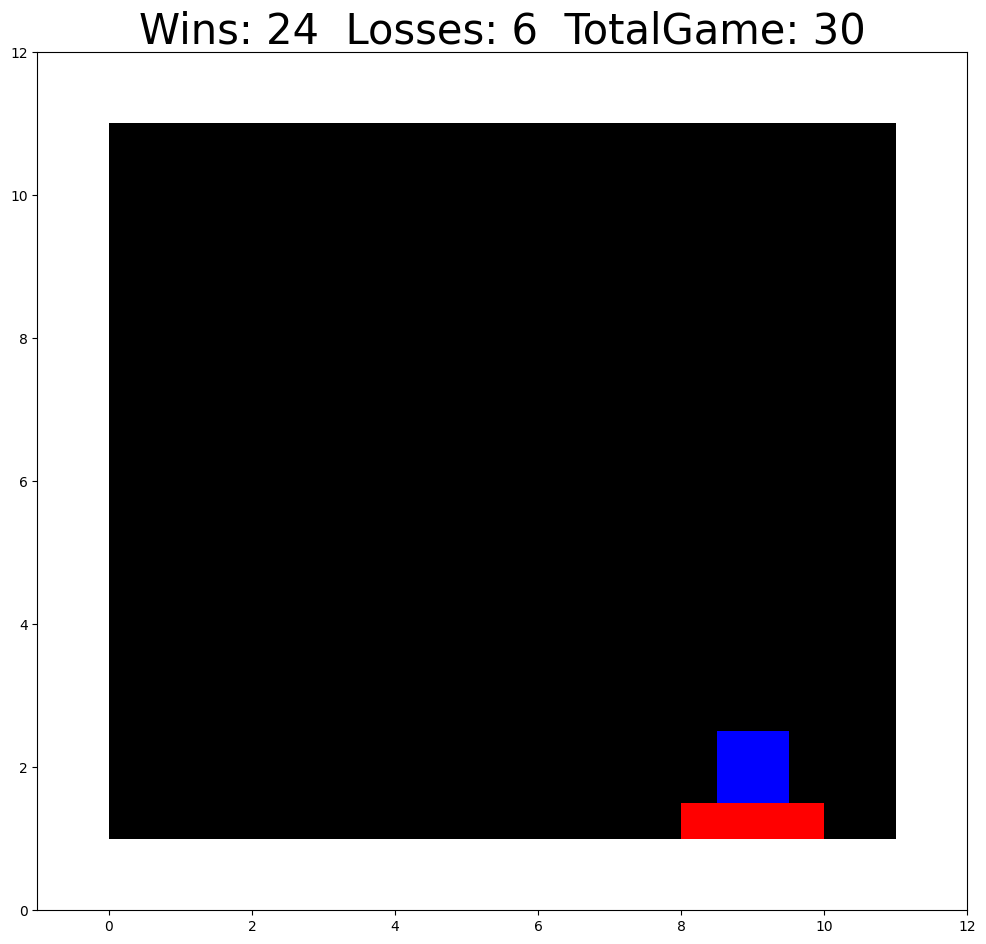

In [17]:
# 화면을 그리기 위한 설정들을 정의합니다.
ground = 1
plot = pl.figure(figsize=(12,12))
axis = plot.add_subplot(111, aspect='equal')
axis.set_xlim([-1, 12])
axis.set_ylim([0, 12])

frame = 1

# maxGames 횟수만큼 게임을 플레이합니다.
while (numberOfGames < maxGames):
  numberOfGames = numberOfGames + 1

  # 최초의 상태를 정의합니다.
  isGameOver = False
  fruitRow, fruitColumn, basket = env.reset()
  currentState = env.observe()
  drawState(fruitRow, fruitColumn, basket, gridSize)

  while (isGameOver != True):
    # 현재 상태를 DQN의 입력값으로 넣고 구한 Q값중 가장 큰 Q값을 갖는 행동을 취합니다.
    q = DQN_model(currentState).numpy()
    action = q.argmax()

    # 행동을 취하고 다음 상태로 넘어갑니다.
    nextState, reward, gameOver, stateInfo = env.act(action)    
    fruitRow = stateInfo[0]
    fruitColumn = stateInfo[1]
    basket = stateInfo[2]
     
    # 과일을 받아내면 winCount를 1 늘리고 과일을 받아내지 못하면 loseCount를 1 늘립니다.
    if (reward == 1):
      winCount = winCount + 1
    elif (reward == -1):
      loseCount = loseCount + 1

    currentState = nextState
    isGameOver = gameOver
    drawState(fruitRow, fruitColumn, basket, gridSize)
    # 다음 행동을 취하기 전에 0.05초의 일시정지를 줍니다.
#    time.sleep(5)
    plt.savefig('/content/generated_output/image_at_frame_{:04d}.png'.format(frame))
    frame = frame+1

# 최종 출력결과 이미지를 하나로 정리합니다.
display.clear_output(wait=True)

In [18]:
anim_file = '/content/generated_output/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/generated_output/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

<ipython-input-18-b2b7cd20ce6a>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-18-b2b7cd20ce6a>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [19]:
from google.colab import files

files.download(anim_file)
!zip -r /content/file.zip /content/generated_output
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/generated_output/ (stored 0%)
  adding: content/generated_output/image_at_frame_0028.png (deflated 37%)
  adding: content/generated_output/image_at_frame_0015.png (deflated 37%)
  adding: content/generated_output/image_at_frame_0031.png (deflated 37%)
  adding: content/generated_output/image_at_frame_0119.png (deflated 36%)
  adding: content/generated_output/image_at_frame_0036.png (deflated 37%)
  adding: content/generated_output/image_at_frame_0129.png (deflated 36%)
  adding: content/generated_output/image_at_frame_0140.png (deflated 36%)
  adding: content/generated_output/image_at_frame_0027.png (deflated 37%)
  adding: content/generated_output/image_at_frame_0131.png (deflated 36%)
  adding: content/generated_output/image_at_frame_0122.png (deflated 35%)
  adding: content/generated_output/image_at_frame_0042.png (deflated 36%)
  adding: content/generated_output/image_at_frame_0096.png (deflated 35%)
  adding: content/generated_output/image_at_frame_0056.png (defl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>